<a href="https://colab.research.google.com/github/athanoid/eeg-mne-analysis/blob/master/plot_decoding_csp_eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
# Import MNE library into Colab
try:
  import mne
  print('mne: {}'.format(mne.__version__))
except ModuleNotFoundError:
  !pip install mne --upgrade

mne: 0.20.0


In [139]:
# import data with $bash into /content

![ -f /content/ME-graz-block.gdf ] && echo "dataset exist" || wget 'https://my.laseeb.org/~thanos/bci/data/ME-graz-block.gdf'

![ -f /content/chanloc.loc ] && echo "chanloc exist" || wget 'https://my.laseeb.org/~thanos/bci/chanloc.loc'


dataset exist
chanloc exist


In [140]:
'''
===========================================================================
Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)
===========================================================================

Decoding of motor imagery applied to EEG data decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.

'''
# Authors: Thanos <athanasios.vourvopoulos@tecnico.ulisboa.pt>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout, read_custom_montage, find_layout, make_standard_montage, make_eeg_layout
from mne.io import concatenate_raws, read_raw_gdf, read_raw_eeglab
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)



Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)

Decoding of motor imagery applied to EEG data decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.




In [141]:
# #############################################################################
# # Set parameters and read data
fileloc = 'ME-graz-block.gdf' # ME-graz-block.gdf , ME-graz-rand.gdf_proc.set

raw = read_raw_gdf(fileloc, stim_channel=-1, preload=True) #.gdf
#raw = mne.io.read_raw_eeglab(fileloc, preload=True) #.set from eeglab

Extracting EDF parameters from /content/ME-graz-block.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 169631  =      0.000 ...   339.262 secs...


['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15', 'Channel 16', 'Channel 17', 'Channel 18', 'Channel 19', 'Channel 20', 'Channel 21', 'Channel 22', 'Channel 23', 'Channel 24', 'Channel 25', 'Channel 26', 'Channel 27', 'Channel 28', 'Channel 29', 'Channel 30', 'Channel 31', 'Channel 32']
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


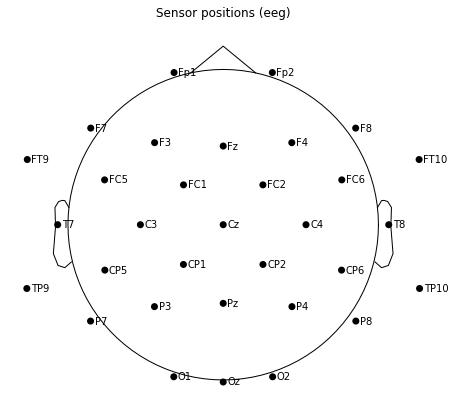

['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'FT10', 'FT9', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8', 'TP10', 'TP9']
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


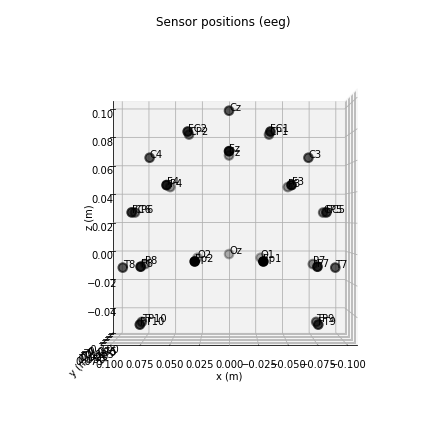

In [142]:
# create montage from channel locations
ch_names = raw.ch_names
print(ch_names)
montage = read_custom_montage('chanloc.loc', coord_frame='head')#32ch
montage.plot(kind='topomap', show_names=True)

ch_loc = montage.ch_names
print(ch_loc)
c = dict(zip(ch_names, ch_loc)) #combine names with locations
raw.rename_channels(c)

raw.set_montage(montage)

fig = montage.plot(kind='3d')
fig.gca().view_init(azim=20, elev=15)


In [143]:
# Apply band-pass filter
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



<RawGDF | ME-graz-block.gdf, 32 x 169632 (339.3 s), ~41.5 MB, data loaded>

In [144]:

tmin, tmax = -1., 4.
event_id = dict(left=7, right=8) # from OpenVibe data
events, _ = events_from_annotations(raw, event_id='auto')

#print(type(events))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 3s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=3.)
labels = epochs.events[:, -1] - 2


Used Annotations descriptions: ['1010', '32769', '32775', '32776', '33282', '768', '769', '770', '781', '786', '800']
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 24 events and 2501 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 31 dim * 3.7e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00034 (2.2e-16 eps * 31 dim * 4.9e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 31 dim * 4.3e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00031 (2.2e-16 eps * 31 dim * 4.5e+10  max singular value)
 

<ipython-input-145-63cbe907b927>:26: DeprecationWarning: Using a layout with topomaps is deprecated and will be removed in 0.21
  csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg', units='Patterns (AU)', size=1.5)


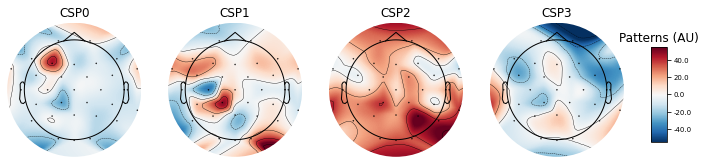

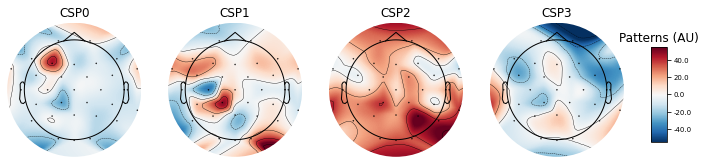

In [145]:
###############################################################################
# Classification with linear discrimant analysis

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=0)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

#layout = read_layout('EEG1005')
layout = find_layout(raw.info, ch_type='eeg', exclude='bads')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg', units='Patterns (AU)', size=1.5)


Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 31 dim * 3.7e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00034 (2.2e-16 eps * 31 dim * 4.9e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 31 dim * 4.3e+10  max singular value)
    Estimated rank (mag): 31
    MAG: rank 31 computed from 31 data channels with 0 projectors
Reducing data rank from 31 -> 31
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00031 (2.2e-16 eps * 31 dim * 4.5e+10  max singular value)
 

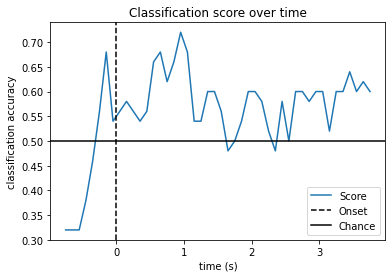

In [146]:
###############################################################################
# Look at performance over time

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()